In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [173]:
#load data
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Tenx/Week 5/data.csv')
df2=pd.read_csv('/content/drive/My Drive/Tenx/Week 5/cleaned.csv')
test=pd.read_csv('/content/drive/My Drive/Tenx/Week 5/test.csv')

In [143]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76529 entries, 0 to 76528
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionId            76529 non-null  object 
 1   BatchId                  76529 non-null  object 
 2   AccountId                76529 non-null  object 
 3   SubscriptionId           76529 non-null  object 
 4   CustomerId               76529 non-null  object 
 5   CurrencyCode             76529 non-null  object 
 6   CountryCode              76529 non-null  int64  
 7   ProviderId               76529 non-null  object 
 8   ProductId                76529 non-null  object 
 9   ProductCategory          76529 non-null  object 
 10  ChannelId                76529 non-null  object 
 11  Amount                   76529 non-null  float64
 12  Value                    76529 non-null  float64
 13  TransactionStartTime     76529 non-null  object 
 14  PricingStrategy       

In [174]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19133 entries, 0 to 19132
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionId            19133 non-null  object 
 1   BatchId                  19133 non-null  object 
 2   AccountId                19133 non-null  object 
 3   SubscriptionId           19133 non-null  object 
 4   CustomerId               19133 non-null  object 
 5   CurrencyCode             19133 non-null  object 
 6   CountryCode              19133 non-null  int64  
 7   ProviderId               19133 non-null  object 
 8   ProductId                19133 non-null  object 
 9   ProductCategory          19133 non-null  object 
 10  ChannelId                19133 non-null  object 
 11  Amount                   19133 non-null  float64
 12  Value                    19133 non-null  float64
 13  TransactionStartTime     19133 non-null  object 
 14  PricingStrategy       

# 1. Calculate RFM for each customer

In [175]:
# Import Script
import proxy
import importlib
importlib.reload(proxy)

<module 'proxy' from '/content/proxy.py'>

In [176]:
#define a snapshot date
df=proxy.get_time(df,'TransactionStartTime')
ref_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)
ref_date

Timestamp('2019-02-14 10:01:28+0000', tz='UTC')

In [177]:
# RFM metrics per customer
rfm = df.groupby('CustomerId').agg({ 'TransactionStartTime': lambda x: (ref_date - x.max()).days,  'CustomerId': 'count', 'Amount': 'sum' }).rename(columns={
    'TransactionStartTime': 'Recency', 'CustomerId': 'Frequency', 'Amount': 'Monetary' }).reset_index()
rfm

,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0
...,...,...,...,...
3737,CustomerId_992,5,6,20000.0
3738,CustomerId_993,26,5,20000.0
3739,CustomerId_994,1,101,543873.0
3740,CustomerId_996,68,17,139000.0


# 2. Cluster Customers

<Axes: >

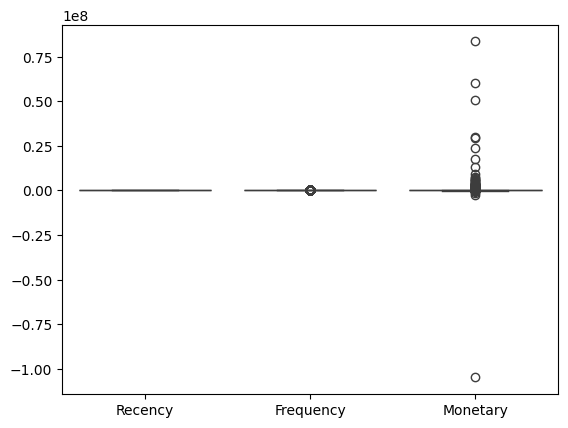

In [178]:
#detect outliers
import seaborn as sns
sns.boxplot(data=rfm[['Recency', 'Frequency', 'Monetary']])


In [179]:
#remove outliers
rfm_c,outlier=proxy.removeoutliers(rfm)

<Axes: >

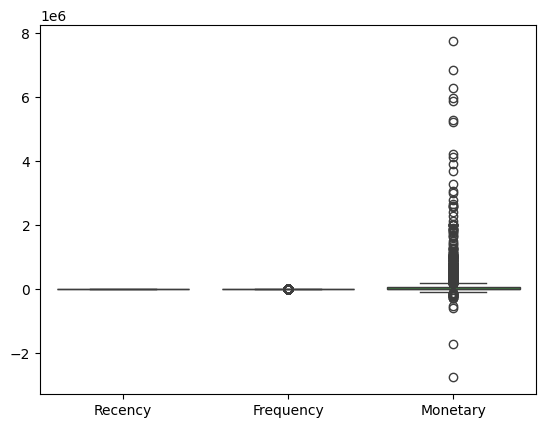

In [180]:
#detect outliers
import seaborn as sns
sns.boxplot(data=rfm_c[['Recency', 'Frequency', 'Monetary']])

In [181]:
# Normalize the RFM values
rfm_temp=rfm_c.copy()
rfm_scaled=proxy.scaler(rfm_temp)
rfm_scaled

,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,1.929143,-0.522293,-0.294501
1,CustomerId_10,1.929143,-0.522293,-0.294501
2,CustomerId_1001,2.150286,-0.412009,-0.217514
3,CustomerId_1002,-0.208572,-0.246583,-0.257996
4,CustomerId_1003,-0.724572,-0.384438,-0.217514
...,...,...,...,...
3737,CustomerId_992,-0.982572,-0.384438,-0.217514
3738,CustomerId_993,-0.208572,-0.412009,-0.217514
3739,CustomerId_994,-1.130001,2.234807,1.126865
3740,CustomerId_996,1.339428,-0.081157,0.087868


In [124]:
rfm.shape

(3703, 5)

In [182]:
# K-means Clustering
rfm_scaled=proxy.clustering(rfm_scaled,["Recency","Frequency","Monetary"])
rfm_c['Cluster']=rfm_scaled["Cluster"]
rfm_c

/tmp/ipython-input-182-1236161475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_c['Cluster']=rfm_scaled["Cluster"]


,CustomerId,Recency,Frequency,Monetary,Cluster
0,CustomerId_1,84,1,-10000.0,1
1,CustomerId_10,84,1,-10000.0,1
2,CustomerId_1001,90,5,20000.0,1
3,CustomerId_1002,26,11,4225.0,0
4,CustomerId_1003,12,6,20000.0,0
...,...,...,...,...,...
3737,CustomerId_992,5,6,20000.0,0
3738,CustomerId_993,26,5,20000.0,0
3739,CustomerId_994,1,101,543873.0,2
3740,CustomerId_996,68,17,139000.0,1


In [183]:
# View cluster statistics
rfm_c.sort_values('Cluster', inplace=True)
cluster_summary = rfm_c.groupby('Cluster').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean',
    'CustomerId': 'count'}).rename(columns={'CustomerId': 'Count'})
cluster_summary

/tmp/ipython-input-183-88011175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_c.sort_values('Cluster', inplace=True)


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,13.093480,18.386865,67656.149492,2086
1,61.632322,6.119972,36561.538920,1417
2,12.935000,134.120000,974940.114550,200


In [184]:
rfm_c['is_high_risk'] = (rfm_c['Cluster'] == 1).astype(int)

/tmp/ipython-input-184-381863395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_c['is_high_risk'] = (rfm_c['Cluster'] == 1).astype(int)


In [185]:
rfm_c

,CustomerId,Recency,Frequency,Monetary,Cluster,is_high_risk
3729,CustomerId_979,12,17,80000.0,0,0
3727,CustomerId_977,10,60,526774.0,0,0
3724,CustomerId_972,12,5,20000.0,0,0
3722,CustomerId_968,5,8,27475.0,0,0
17,CustomerId_1022,35,1,7000.0,0,0
...,...,...,...,...,...,...
1775,CustomerId_3405,9,189,226930.0,2,0
2675,CustomerId_4518,33,166,261280.5,2,0
1292,CustomerId_2816,2,225,235333.4,2,0
792,CustomerId_2111,1,111,247368.0,2,0


In [186]:
#Merge result
df_merged = df2.merge(rfm_c[['CustomerId','is_high_risk']], on='CustomerId', how='left')

In [188]:
#drop Outliers
outlier_customers = rfm.loc[outlier, 'CustomerId'].tolist()
df_merged=df_merged[~df_merged['CustomerId'].isin(outlier_customers)]

In [189]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59035 entries, 0 to 76527
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionId            59035 non-null  object 
 1   BatchId                  59035 non-null  object 
 2   AccountId                59035 non-null  object 
 3   SubscriptionId           59035 non-null  object 
 4   CustomerId               59035 non-null  object 
 5   CurrencyCode             59035 non-null  object 
 6   CountryCode              59035 non-null  int64  
 7   ProviderId               59035 non-null  object 
 8   ProductId                59035 non-null  object 
 9   ProductCategory          59035 non-null  object 
 10  ChannelId                59035 non-null  object 
 11  Amount                   59035 non-null  float64
 12  Value                    59035 non-null  float64
 13  TransactionStartTime     59035 non-null  object 
 14  PricingStrategy          59

In [190]:
df_merged.to_csv('train_processed.csv', index=False)

In [196]:
#Process test data
test_merged = test.merge(rfm_c[['CustomerId','is_high_risk']], on='CustomerId', how='left')
test_merged=test_merged[~test_merged['CustomerId'].isin(outlier_customers)]

In [200]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19133 entries, 0 to 19132
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionId            19133 non-null  object 
 1   BatchId                  19133 non-null  object 
 2   AccountId                19133 non-null  object 
 3   SubscriptionId           19133 non-null  object 
 4   CustomerId               19133 non-null  object 
 5   CurrencyCode             19133 non-null  object 
 6   CountryCode              19133 non-null  int64  
 7   ProviderId               19133 non-null  object 
 8   ProductId                19133 non-null  object 
 9   ProductCategory          19133 non-null  object 
 10  ChannelId                19133 non-null  object 
 11  Amount                   19133 non-null  float64
 12  Value                    19133 non-null  float64
 13  TransactionStartTime     19133 non-null  object 
 14  PricingStrategy       

In [199]:
test_merged.to_csv('test_processed.csv', index=False)